In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import multiprocessing
import os
import neat
import visualize

import warnings
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

def eval_genome(genome, config):
    """
    This function will be run in parallel by ParallelEvaluator.  It takes two
    arguments (a single genome and the genome class configuration data) and
    should return one float (that genome's fitness).

    Note that this function needs to be in module scope for multiprocessing.Pool
    (which is what ParallelEvaluator uses) to find it.  Because of this, make
    sure you check for __main__ before executing any code (as we do here in the
    last few lines in the file), otherwise you'll have made a fork bomb
    instead of a neuroevolution demo. :)
    """
    if_no_connect = True
    
    net = neat.nn.FeedForwardNetwork.create(genome, config)
    error = 0.0
    for xi, xo in zip(x_inputs, x_outputs):
        output = net.activate(xi)
        # error -= (output[0] - xo[0]) ** 2
        error -= np.abs(output[0] - xo[0])
        if float(output[0]) != 0:
            if_no_connect = False
    
    if if_no_connect:
        mse = -20
    else:
        mse = error/L
    # mad = error/L
    return mse


def run(config_file):
    # Load configuration.
    config = neat.Config(
        neat.DefaultGenome,
        neat.DefaultReproduction,
        neat.DefaultSpeciesSet,
        neat.DefaultStagnation,
        config_file,
    )

    # Create the population, which is the top-level object for a NEAT run.
    p = neat.Population(config)

    # Add a stdout reporter to show progress in the terminal.
    p.add_reporter(neat.StdOutReporter(True))
    stats = neat.StatisticsReporter()
    p.add_reporter(stats)

    # Run for up to 300 generations.
    pe = neat.ParallelEvaluator(multiprocessing.cpu_count(), eval_genome)
    winner = p.run(pe.evaluate, 100)

    return [stats,winner]

In [2]:
def ackley(a):
    d = len(a)
    term1 = - 20 * np.exp(-0.2*np.sqrt(np.sum(a**2)/d))
    term2 = - np.exp(np.sum(np.cos(a*2*np.pi))/d)
    f = term1 + term2 + 20 + np.exp(1)
    return f

In [22]:
d = 10

x_inputs = []
x_outputs = []
list_outputs = []

for i in range(1000):
    A = -32.768
    B = 32.768#小数的范围A ~ B
    a = np.random.uniform(A,B,d)
    x_inputs.append(tuple(a/A))
    y = ackley(a)
    list_outputs.append(y)

for i in range(1000):
    x_outputs.append(tuple([list_outputs[i]/np.max(list_outputs)]))

In [28]:
[tuple([0,0,0,0,0,0,0,0,0,0])]

[(0, 0, 0, 0, 0, 0, 0, 0, 0, 0)]

In [6]:
A = -32.768
B = 32.768#小数的范围A ~ B
a = np.random.uniform(A,B,d)
x_inputs.append(tuple(a))
y = ackley(a)
x_outputs.append(tuple([y]))

In [ ]:
local_dir = os.getcwd()
config_path = os.path.join(local_dir, "config-feedforward")

stats_list = []
winner_list = []
for i in range(1):
    [stats,winner] = run(config_path)
    stats_list.append(stats)
    winner_list.append(winner)


 ****** Running generation 0 ****** 



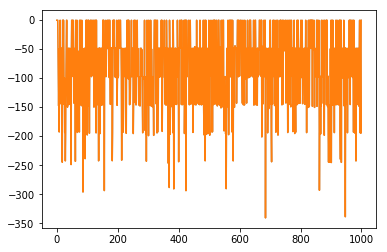

In [75]:
avg_fitness_list = []
best_list = []

for i in range(1):
    generation = range(len(stats_list[i].get_fitness_mean()))
    avg_fitness = np.array(stats_list[i].get_fitness_mean())
    avg_fitness_list.append(avg_fitness)
    best_fitness = [c.fitness for c in stats_list[i].most_fit_genomes]
    best_list.append(best_fitness)

    plt.plot(generation, avg_fitness, alpha = 0.4)
    #plt.plot(generation, best_fitness, alpha = 0.4)

plt.plot(generation, np.average(np.array(avg_fitness_list),axis = 0), label="Average")
#plt.plot(generation, np.average(np.array(best_list),axis = 0), label="Best")


plt.show()

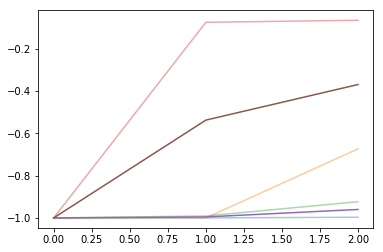

In [22]:
avg_fitness_list = []
best_list = []

for i in range(2):
    generation = range(len(stats_list[i].get_fitness_mean()))
    avg_fitness = np.array(stats_list[i].get_fitness_mean())
    avg_fitness_list.append(avg_fitness)
    best_fitness = [c.fitness for c in stats_list[i].most_fit_genomes]
    best_list.append(best_fitness)

    plt.plot(generation, avg_fitness, alpha = 0.4)
    plt.plot(generation, best_fitness, alpha = 0.4)

plt.plot(generation, np.average(np.array(avg_fitness_list),axis = 0), label="Average")
plt.plot(generation, np.average(np.array(best_list),axis = 0), label="Best")


plt.show()

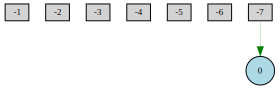

In [12]:
import graphviz
draw_net(config, winner_list[0])

In [10]:
def draw_net(
    config,
    genome,
    view=False,
    filename=None,
    node_names=None,
    show_disabled=True,
    prune_unused=False,
    node_colors=None,
    fmt="png",
):
    """ Receives a genome and draws a neural network with arbitrary topology. """
    # Attributes for network nodes.
    if graphviz is None:
        warnings.warn(
            "This display is not available due to a missing optional dependency (graphviz)"
        )
        return

    if node_names is None:
        node_names = {}

    assert type(node_names) is dict

    if node_colors is None:
        node_colors = {}

    assert type(node_colors) is dict

    node_attrs = {"shape": "circle", "fontsize": "9", "height": "0.2", "width": "0.2"}

    dot = graphviz.Digraph(format=fmt, node_attr=node_attrs)

    inputs = set()
    for k in config.genome_config.input_keys:
        inputs.add(k)
        name = node_names.get(k, str(k))
        input_attrs = {
            "style": "filled",
            "shape": "box",
            "fillcolor": node_colors.get(k, "lightgray"),
        }
        dot.node(name, _attributes=input_attrs)

    outputs = set()
    for k in config.genome_config.output_keys:
        outputs.add(k)
        name = node_names.get(k, str(k))
        node_attrs = {"style": "filled", "fillcolor": node_colors.get(k, "lightblue")}

        dot.node(name, _attributes=node_attrs)

    if prune_unused:
        connections = set()
        for cg in genome.connections.values():
            if cg.enabled or show_disabled:
                connections.add((cg.in_node_id, cg.out_node_id))

        used_nodes = copy.copy(outputs)
        pending = copy.copy(outputs)
        while pending:
            new_pending = set()
            for a, b in connections:
                if b in pending and a not in used_nodes:
                    new_pending.add(a)
                    used_nodes.add(a)
            pending = new_pending
    else:
        used_nodes = set(genome.nodes.keys())

    for n in used_nodes:
        if n in inputs or n in outputs:
            continue

        attrs = {"style": "filled", "fillcolor": node_colors.get(n, "white")}
        dot.node(str(n), _attributes=attrs)

    for cg in genome.connections.values():
        if cg.enabled or show_disabled:
            # if cg.input not in used_nodes or cg.output not in used_nodes:
            #    continue
            input, output = cg.key
            a = node_names.get(input, str(input))
            b = node_names.get(output, str(output))
            style = "solid" if cg.enabled else "dotted"
            color = "green" if cg.weight > 0 else "red"
            width = str(0.1 + abs(cg.weight / 5.0))
            dot.edge(
                a, b, _attributes={"style": style, "color": color, "penwidth": width}
            )

    dot.render(filename, view=view)

    return dot